### Using this file to build a co-occurrence function and attempt to perform named entity recognition

In [2]:
import pandas as pd
import spacy
from itertools import combinations
import networkx as nx
from collections import defaultdict
import operator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_csv('final_data_for_modeling.csv')

In [4]:
data.head()

,tweet,class,date_posted
0,If you are heading to and beyond going SB on ...,0,2017-12-13 23:22:50+00:00
1,"Due to bridge repairs, TxDOT has closed two al...",0,2017-12-13 01:35:30+00:00
2,Good news. All mainlanes of I-45 N Frwy NB bet...,0,2017-12-04 02:46:13+00:00
3,I-45 Northbound direct connector project conti...,0,2017-12-01 14:49:35+00:00
4,Two incident on I-10 Katy Frwy are significant...,0,2017-11-28 22:18:29+00:00


In [5]:
# ner list to user
nlp = spacy.load('en_core_web_sm')

In [6]:
doc = nlp(data['tweet'][1])

In [7]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_) # returns text, starting and ending character and label

TxDOT 23 28 ORG
two 40 43 CARDINAL
I-45 Gulf Frwy NB 67 84 EVENT
Tiki 88 92 GPE
the Galveston Causeway 102 124 FAC
mid-March 152 161 DATE


In [8]:
# remove duplicate tweets
tweets = data.tweet.unique()

In [10]:
docs = nlp.pipe(tweets)

In [9]:
data.dtypes

tweet          object
class           int64
date_posted    object
dtype: object

In [11]:
entities = pd.DataFrame({'tweet': tweet_indexes,
             'entities': tweet_entities})

In [12]:
tweets = tweets.astype('str')

In [13]:
x = nlp.pipe(tweets, n_threads=3)

tweets = [str(tweet) for tweet in tweets]

tweet_counter = 0 

#creat an edige list of all topics that co-occur
for doc in nlp.pipe(tweets, n_threads=3):
    for ent in doc.ents:
        
        tweet_indexes.append(tweet_counter)
        tweet_entities.append(ent.text)
    tweet_counter += 1
             

In [14]:
ner = pd.DataFrame({'tweet': tweet_indexes,
             'entities': tweet_entities})

In [15]:
ner['entities'].drop_duplicates(inplace=True)

In [16]:
# this function takes a string or array of strings and returns a dictionary of dictionaries with a count
# of how often each unit co-occurs
# Function from stackoverflow user Patrick Maupin
# for each entity pair that occurs in the corpus
# For each entity pair that occurs together in the same tweet, 
# record the number of times they occur together in the whole corpus

# pair named entities
def coocurrence(common_entities):
    com = defaultdict(int)
    
    #build a co-occurrence matrix:
    for w1, w2 in combinations(sorted(common_entities), 2):
        com[w1, w2] += 1
        
    result = defaultdict(dict)
    for (w1, w2), count in com.items():
        if w1 != w2:
            result[w1][w2] = {'weight': count}
            
    return result



In [17]:
print(coocurrence('abcaqwvv'))

defaultdict(<class 'dict'>, {'a': {'b': {'weight': 2}, 'c': {'weight': 2}, 'q': {'weight': 2}, 'v': {'weight': 4}, 'w': {'weight': 2}}, 'b': {'c': {'weight': 1}, 'q': {'weight': 1}, 'v': {'weight': 2}, 'w': {'weight': 1}}, 'c': {'q': {'weight': 1}, 'v': {'weight': 2}, 'w': {'weight': 1}}, 'q': {'v': {'weight': 2}, 'w': {'weight': 1}}, 'v': {'w': {'weight': 2}}})


In [18]:
docs = nlp(tweets[0])

coocurrence(docs.ents)

defaultdict(dict,
            {US: {59: {'weight': 1}, morning hours: {'weight': 1}},
             59: {morning hours: {'weight': 1}}})

In [19]:
# built function in order to use network x from dict of dicts


In [20]:
tweets = data.tweet.unique()

tweets = [str(tweet) for tweet in tweets]

nlp = spacy.load('en_core_web_sm')

In [21]:
coocur_edges = {}

for doc in nlp.pipe(tweets, n_threads=3):
    coocur_edges.update(coocurrence(doc.ents))

In [23]:
corpus = list(nlp.pipe(tweets))

In [24]:
all_ents = defaultdict(int)

for i, doc in enumerate(corpus):
    #print(i,doc)
    for ent in doc.ents:
        all_ents[str(ent)] += 1
        
print('Number of distinct entities: ', len(all_ents))

Number of distinct entities:  8689


In [25]:
sorted_ents = sorted(all_ents.items(), key=operator.itemgetter(1), reverse=True)
sorted_ents[:20]

[('610', 861),
 ('1', 683),
 ('Houston', 628),
 ('69', 564),
 ('Verified', 397),
 ('today', 394),
 ('two', 377),
 ('2', 303),
 ('NorthSide', 300),
 ('290', 275),
 ('SouthSide', 266),
 ('Harris', 250),
 ('45', 233),
 ('3', 190),
 ('SeSide', 186),
 ('NwSide', 182),
 ('tonight', 181),
 ('Shoulder', 174),
 ('5am', 160),
 ('Hwy 288', 151)]

In [26]:
# Number of ents that appear at least twice

multi_ents = [x for x in sorted_ents if x[1] > 1]

print('Number of ents that appear at least twice: ', len(multi_ents))

Number of ents that appear at least twice:  3035


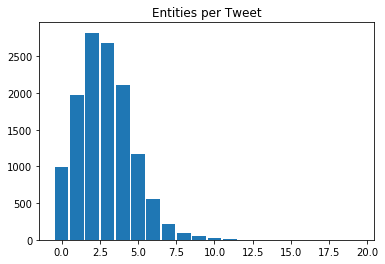

In [28]:
# How many ents appear per tweet?

ents_in_tweets = [len(doc.ents) for doc in corpus]

plt.hist(ents_in_tweets, 
         rwidth=0.9, 
         bins=np.arange(max(ents_in_tweets)+2)-0.5)  
        # Futzing with bins just to fix column alignment - not really necessary
plt.title('Entities per Tweet')
plt.show()

In [29]:
tweet_ents = []
for i, doc in enumerate(nlp.pipe(tweets)):
    string_ents = list(map(str, doc.ents))
    tweet_ents.append(string_ents)
    # Doubling some up to fake/force coocurrence
    if i%2==0:
        tweet_ents.append(string_ents)  
#tweet_ents

In [30]:
# Can filter out tweets with only 1 ent (nothing to coocur with)

multi_ent_tweets = [t for t in tweet_ents if len(t)>1]
# single_ent_tweets = [t for t in tweet_ents if len(c)==1]
# no_ent_tweets = [t for t in tweet_ents if len(c)==0]

In [32]:
def coocurrence(*inputs):
    com = defaultdict(int)
    
    for named_entities in inputs:
        # Build co-occurrence matrix
        for w1, w2 in combinations(sorted(named_entities), 2):
            com[w1, w2] += 1
            com[w2, w1] += 1  #Including both directions

    result = defaultdict(dict)
    for (w1, w2), count in com.items():
        if w1 != w2:
            result[w1][w2] = {'weight': count}
    return result

In [34]:
# Generating coocurrence dict of dicts

coocur_edges = coocurrence(*multi_ent_tweets)

In [35]:
# Filter out ents with < min_weight - useful for graph clarity?

def filter_ents_by_min_weight(edges, min_weight):
    coocur_edges_filtered = defaultdict()
    for k1, e in edges.items():
        ents_over_x_weight = {k2: v for k2, v in e.items() if v['weight'] > min_weight}
        if ents_over_x_weight:  # ie. Not empty
            coocur_edges_filtered[k1] = ents_over_x_weight
    return coocur_edges_filtered

In [36]:

filtered_edges = filter_ents_by_min_weight(coocur_edges, 2)

coocur_sum = defaultdict(int)
for k1, e in filtered_edges.items():
    for k2, v in e.items():
        coocur_sum[k1] += v['weight']

sorted_coocur = sorted(coocur_sum.items(), key=operator.itemgetter(1), reverse=True)
print('Most frequent CO-ocurring entity:')
sorted_coocur[0:10]

Most frequent CO-ocurring entity:


[('610', 3738),
 ('1', 2467),
 ('69', 2279),
 ('two', 1630),
 ('Verified', 1481),
 ('Houston', 1433),
 ('290', 1153),
 ('45', 1132),
 ('NorthSide', 1082),
 ('5am', 1074)]

/Users/nicolasavega/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


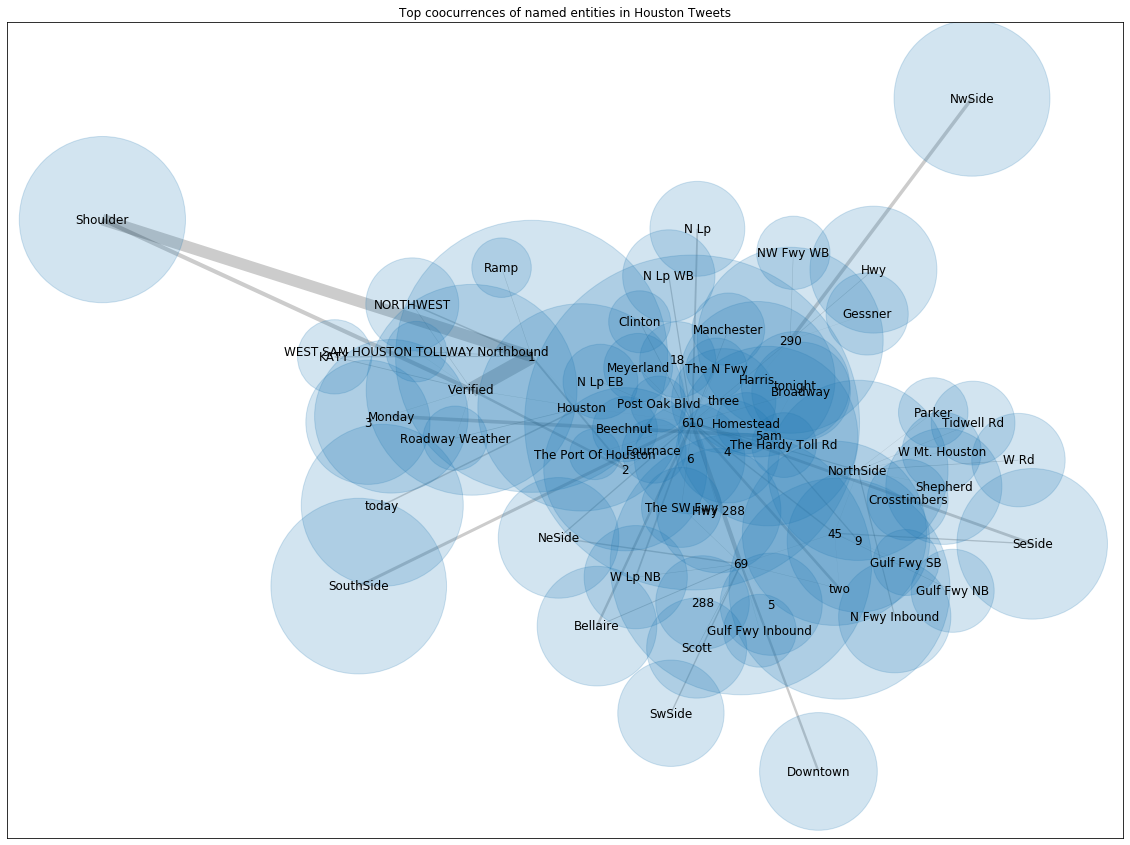

In [37]:
## code adapted from kaggle codealong to graph entity co-occurrence. 
# https://www.youtube.com/watch?v=4SoLoo0fdH0


top_n = 10
min_weight = 30 # can play with this setting to return different amounts of named entities in the visual below. 
# set to 30 for ease of presenting this visual
figsize = (20, 15)
scale_nodes = lambda x: (x * 30) + 1
scale_edges = lambda x: 15 * x

filtered_edges = filter_ents_by_min_weight(coocur_edges, min_weight)

top_cooccur = [x[0] for x in sorted_coocur[:top_n]]  
graph_edges = {k:filtered_edges[k] for k in top_cooccur}

# Attempting to graph these top coocurrances
G = nx.from_dict_of_dicts(graph_edges)
pos = nx.kamada_kawai_layout(G)


# Normalise, then scale the line weights
weights = [G[u][v]['weight'] for u, v in G.edges() if u != v]
weights = list(map(lambda x: (x - min(weights)) / (max(weights) - min(weights)), weights))
weights = list(map(scale_edges, weights))

# Scale node weights 
sum_weights = [coocur_sum[n] if coocur_sum[n]>0 else 1 for n in G.nodes]
sum_weights = list(map(scale_nodes, sum_weights))



plt.figure(figsize=figsize)

# nx.draw(G, pos)
nx.draw_networkx_edges(G, pos, alpha=0.2, width=weights)
nx.draw_networkx_nodes(G, pos, alpha=0.2, node_size=sum_weights)
nx.draw_networkx_labels(G, pos)

plt.xticks([])
plt.yticks([])

plt.title('Top coocurrences of named entities in Houston Tweets')
plt.show()